#ASSIGNMENT-1


1)

         Date        Open        High         Low       Close   Adj Close  \
0  2023-06-26  186.830002  188.050003  185.229996  185.270004  184.291275   
1  2023-06-27  185.889999  188.389999  185.669998  188.059998  187.066528   
2  2023-06-28  187.929993  189.899994  187.600006  189.250000  188.250244   
3  2023-06-29  189.080002  190.070007  188.940002  189.589996  188.588440   
4  2023-06-30  191.630005  194.479996  191.259995  193.970001  192.945328   

     Volume  
0  48088700  
1  50730800  
2  51216800  
3  46347300  
4  85069600  
X_train shape: (170, 20)
X_test shape: (40, 20)
First X_train sequence: [0.39229736 0.44629377 0.46932458 0.47590472 0.56067355 0.53144974
 0.50958009 0.51886973 0.49700008 0.4569383  0.44668092 0.47938852
 0.49429057 0.49719379 0.5610607  0.55602859 0.5825432  0.54441661
 0.52138578 0.53706215]
First y_train value: 0.5538996730752728
2/2 [==============================] - 2s 16ms/step
Mean Squared Error (MSE): 30.9627036960523
Root Mean Squared Err

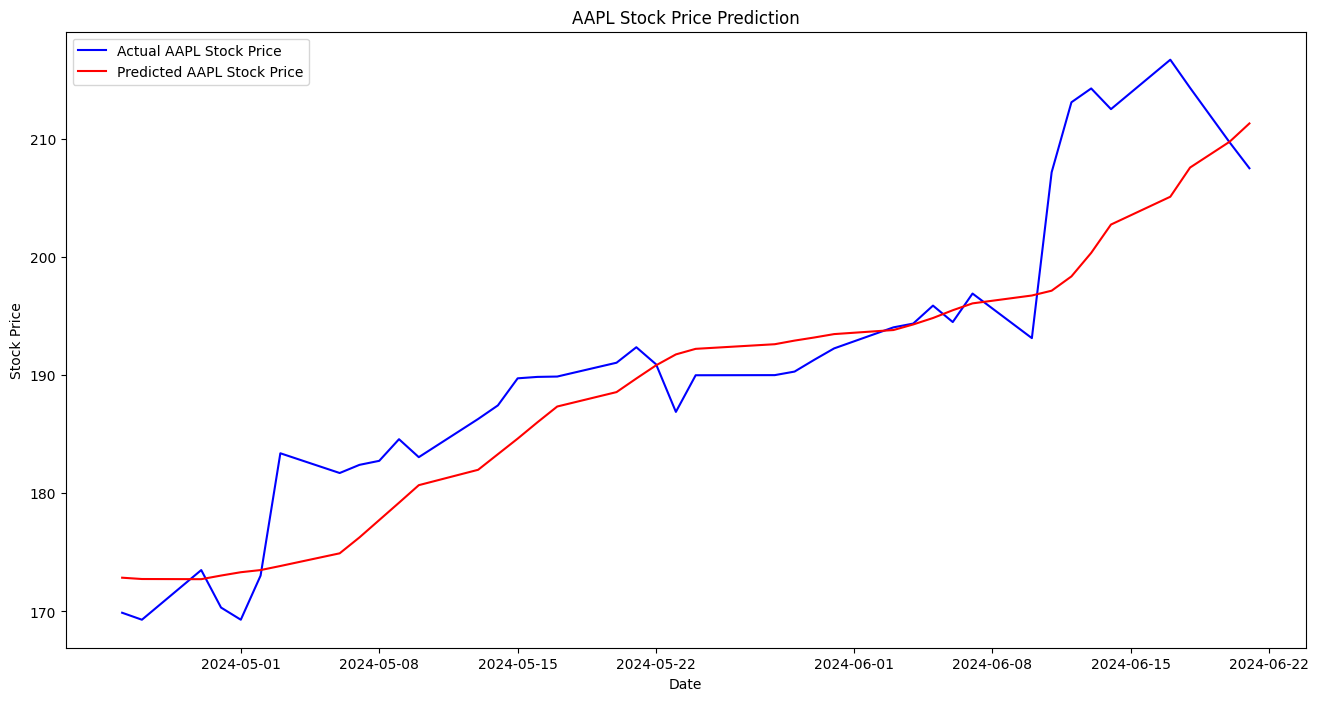

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Loading the data of APPLE.INC
df = pd.read_csv('AAPL.csv')

# Check the structure of the dataset
print(df.head())

# Use the 'Date' column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the 'Close' price for prediction
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_data_len = len(scaled_data) - 60  # Adjusting for a smaller test size
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]

# Adjusted sequence length
seq_length = 20  # Reduced sequence length

# Create the training data sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Check shapes and first few elements
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'First X_train sequence: {X_train[0] if len(X_train) > 0 else "No data"}')
print(f'First y_train value: {y_train[0] if len(y_train) > 0 else "No data"}')

# Reshape the data to fit the LSTM model
if len(X_train.shape) == 2 and len(X_test.shape) == 2:
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=1, epochs=1)

    # Get the model's predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(actual_prices, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predictions)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')

    # Plot the predictions
    plt.figure(figsize=(16,8))
    plt.plot(df.index[-len(predictions):], actual_prices, color='blue', label='Actual AAPL Stock Price')
    plt.plot(df.index[-len(predictions):], predictions, color='red', label='Predicted AAPL Stock Price')
    plt.title('AAPL Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Save the model
    model.save('aapl_lstm_model.h5')

else:
    print("Not enough data to test the model.")


2)

1/1 [==============================] - 0s 22ms/step


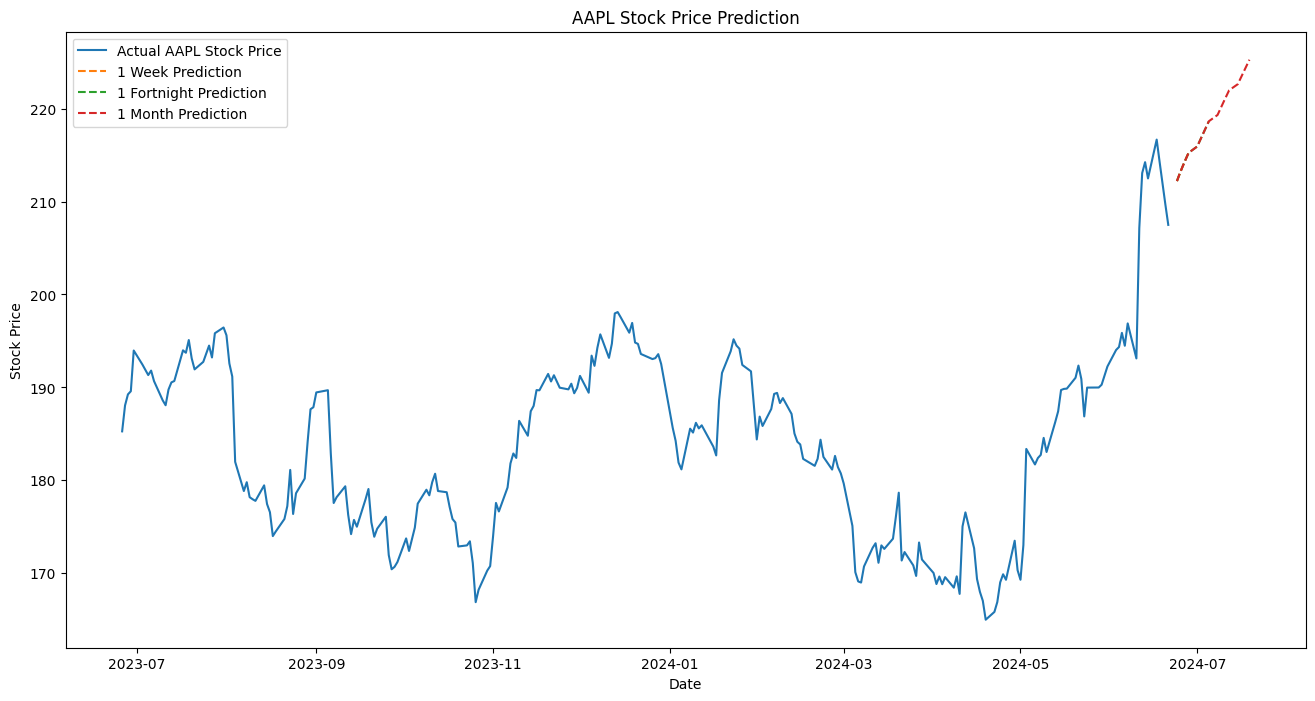

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the data
df = pd.read_csv('AAPL.csv')

# Use the 'Date' column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the 'Close' price for prediction
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Use the last sequence_length data points to predict future values
sequence_length = 20
last_sequence = scaled_data[-sequence_length:]

# Load the trained model
model = load_model('aapl_lstm_model.h5')

# Function to make future predictions
def predict_future(model, last_sequence, future_steps):
    predictions = []
    current_sequence = last_sequence

    for _ in range(future_steps):
        # Prepare the current sequence for prediction
        current_sequence_reshaped = current_sequence.reshape(1, sequence_length, 1)

        # Predict the next value
        next_value = model.predict(current_sequence_reshaped)

        # Append the prediction to the list
        predictions.append(next_value[0, 0])

        # Update the sequence with the new predicted value
        current_sequence = np.append(current_sequence[1:], next_value, axis=0)

    return predictions

# Predict the next week (5 days), fortnight (10 days), and month (20 days)
future_steps_week = 5
future_steps_fortnight = 10
future_steps_month = 20

predictions_week = predict_future(model, last_sequence, future_steps_week)
predictions_fortnight = predict_future(model, last_sequence, future_steps_fortnight)
predictions_month = predict_future(model, last_sequence, future_steps_month)

# Inverse transform the predictions to get actual values
predictions_week_actual = scaler.inverse_transform(np.array(predictions_week).reshape(-1, 1))
predictions_fortnight_actual = scaler.inverse_transform(np.array(predictions_fortnight).reshape(-1, 1))
predictions_month_actual = scaler.inverse_transform(np.array(predictions_month).reshape(-1, 1))

# Create a DataFrame for comparison
future_dates_week = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps_week, freq='B')
future_dates_fortnight = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps_fortnight, freq='B')
future_dates_month = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps_month, freq='B')

# Create a DataFrame with future dates
future_dates = future_dates_month
predictions_df = pd.DataFrame(index=future_dates, data={
    '1 Week Prediction': np.nan,
    '1 Fortnight Prediction': np.nan,
    '1 Month Prediction': np.nan
})

# Fill in the predictions
predictions_df.iloc[:future_steps_week, 0] = predictions_week_actual.flatten()
predictions_df.iloc[:future_steps_fortnight, 1] = predictions_fortnight_actual.flatten()
predictions_df.iloc[:future_steps_month, 2] = predictions_month_actual.flatten()

# Plot the predictions
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Actual AAPL Stock Price')

# Add future predictions to the plot
plt.plot(predictions_df.index, predictions_df['1 Week Prediction'], label='1 Week Prediction', linestyle='--')
plt.plot(predictions_df.index, predictions_df['1 Fortnight Prediction'], label='1 Fortnight Prediction', linestyle='--')
plt.plot(predictions_df.index, predictions_df['1 Month Prediction'], label='1 Month Prediction', linestyle='--')

plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#REPORT

                SoC Report on LSTM Model for AAPL Stock Price Prediction
                                         22B2157 B.charan
Model Architecture:
•	Libraries Used: numpy, pandas, sklearn (for MinMaxScaler), matplotlib.pyplot, tensorflow.keras.

•	Data Source: CSV file named AAPL.csv of APPLE downloaded from Yahoo finance

•	Model Architecture:

o	Input Layer: LSTM with 50 units, return sequences

o	Dropout Layer: Dropout rate of 20% to prevent overfitting

o	Hidden Layer: LSTM with 50 units

o	Dropout Layer: Dropout rate of 20%

o	Output Layer: Dense layer with 25 units followed by another Dense layer with 1 unit (for regression).

o	Optimizer: Adam optimizer

o	Loss Function: Mean Squared Error (MSE).

Data Loading and Preprocessing:

•	The data is loaded from AAPL.csv and the 'Date' column is converted to a datetime index.

•	Only the 'Close' prices are selected for prediction.

•	Data is scaled using MinMaxScaler to normalize values between 0 and 1.
Training Configuration:

•	Sequence Length: 20 (for creating sequences).

•	Number of Epochs: 1 (for demonstration purposes; typically, more epochs are used for training).

•	Batch Size: 1 (one sequence at a time due to constraints).

Model Training:

•	The model is trained on the scaled training data (X_train, y_train) for 1 epoch.

•	Batch size is set to 1 for demonstration; adjust for efficiency based on hardware and model constraints.
Prediction and Evaluation:

•	Prediction: Predictions are made for future stock prices using the last 20 data points.

•	Evaluation Metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) are calculated for model performance evaluation.

Visualization:

•	Predicted prices are plotted against actual prices to visualize the model's performance.  

•	Future predictions (1 week, 1 fortnight, and 1 month) are overlaid but I couldn’t find the reason why i can’t predict 1week,1 fortnight predictions.

Conclusion:

•	The LSTM model demonstrates the ability to predict future stock prices based on historical data.

•	I tried to predict 1 week, 1 fortnight but I couldn’t find the reason why I am not able to predict them.

•	Further optimization can be achieved by tuning hyperparameters such as batch size, number of epochs, and model architecture.

•	Hardware considerations (like GPU utilization) could enhance training and prediction efficiency.

